In [1]:
hyperparams = {
    "dataset": "CassavaNew",  # this is for salt stress dataset
    "folder": "Data/",
    "model": "irf",
    "epoch": 200,
    "runs": 10,
    "flag": 0,
    "training_sample": 0.7,
    "val_size": 0,
    "sampling_mode": "kfold",
    "lr": 0.0002,
    "patch_size": 17,
    "batch_size": 256,
    "ignored_labels": 0,
    "norm_type": "scale",
    "padded": 1,
    "dmodel": 96,
    "nhead": 4,
    "depth": 5,
    "dropout": 0.1,
    "ignored_labels": [0],
    "supervision": "full",
    "device": "cuda",
    "Beta": 1,  # this is wor class weight loss for imbalance data
    "channels": 1,
    "restore": None,
}

In [2]:
from HSI import *
HSIs = HSI(**hyperparams)

Data/CassavaNew/
gt:  [1 1 1 ... 3 3 3]


In [3]:
from sklearn.decomposition import PCA

data = preprocessing.scale(HSIs.img)

#using PCA
pca = PCA(n_components=30)
data_pca = pca.fit_transform(data)
data_img = data_pca

/home/nafkhanzam/kode/its/penelitian-vit-wn/experiments/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/nafkhanzam/kode/its/penelitian-vit-wn/experiments/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [4]:
from experiment import Experiment

Ex = Experiment(HSIs.gt, **hyperparams)
Ex.set_train_test(HSIs.gt, 0)  # set the training and testing
y_train = HSIs.gt[tuple(Ex.training_indices)]   # reduce each indices with 1 --> this is 1D array
y_test = HSIs.gt[tuple(Ex.testing_indices)]
data_spatial = data_img
x_train_temp = data_spatial[tuple(Ex.training_indices),:]
x_train =x_train_temp.reshape (x_train_temp.shape[1], x_train_temp.shape[2])
x_test_temp = data_spatial[tuple(Ex.testing_indices),:]
x_test = x_test_temp.reshape(x_test_temp.shape[1],x_test_temp.shape[2])

i 0


In [5]:
import irf
from irf import (irf_utils, utils,
                 irf_jupyter_utils)
from irf.ensemble.wrf import RandomForestClassifierWithWeights

rf = RandomForestClassifierWithWeights(n_estimators=100,random_state=42)
all_rf_weights, all_K_iter_rf_data, \
    all_rf_bootstrap_output, all_rit_bootstrap_output, \
    stability_score = irf_utils.run_iRF(
        X_train=x_train,
        X_test=x_test,
        y_train=y_train,
        y_test=y_test,
        K=5,
        rf=rf,
        B=30,
        random_state_classifier=2018,
        propn_n_samples=.2,
        bin_class_type=1,
        M=20,
        max_depth=5,
        noisy_split=False,
        num_splits=2,
        signed=True,
        n_estimators_bootstrap=5,
    )

In [6]:
all_rf_weights

{'rf_weights0': None,
 'rf_weight1': array([0.02624977, 0.02719121, 0.05181739, 0.04295387, 0.0401327 ,
        0.03197939, 0.03657223, 0.04120558, 0.02828327, 0.04238387,
        0.03478646, 0.02929257, 0.03591886, 0.04853575, 0.02333126,
        0.04977181, 0.04509115, 0.03456969, 0.03407168, 0.0358645 ,
        0.02783816, 0.02318948, 0.02361889, 0.02491586, 0.02309826,
        0.02764734, 0.02954346, 0.02363408, 0.03475461, 0.02175686]),
 'rf_weight2': array([0.0195778 , 0.02188404, 0.06587942, 0.0481205 , 0.04240173,
        0.03090147, 0.04038954, 0.0451527 , 0.02184092, 0.05194951,
        0.0334442 , 0.02497929, 0.03808968, 0.06455336, 0.01880477,
        0.06481196, 0.05495997, 0.03561143, 0.02939267, 0.03769554,
        0.02167655, 0.01850796, 0.01806822, 0.01724532, 0.01612826,
        0.02220221, 0.02567738, 0.01792692, 0.03676977, 0.01535687]),
 'rf_weight3': array([0.01527273, 0.01827608, 0.07908283, 0.05720104, 0.04657764,
        0.02869748, 0.0420143 , 0.0480302 , 0.01

In [7]:
final_weights = all_rf_weights['rf_weight5']
final_weights

array([0.00823424, 0.01366633, 0.09102159, 0.06662554, 0.05060338,
       0.02476641, 0.04821344, 0.05210686, 0.01023939, 0.06347066,
       0.03126246, 0.01418941, 0.04243905, 0.08786057, 0.00882446,
       0.08195443, 0.06864876, 0.04070108, 0.02421579, 0.04131066,
       0.011224  , 0.01123844, 0.00823912, 0.00735075, 0.00573795,
       0.01116878, 0.01894208, 0.00586793, 0.04238507, 0.00749138])

In [8]:
final_rf = RandomForestClassifierWithWeights(n_estimators=100,random_state=42)
final_rf.fit(x_train, y_train, feature_weight=final_weights)
y_pred = final_rf.predict(x_test)
y_pred

array([1, 1, 1, ..., 2, 2, 3], dtype=uint8)

In [9]:
from sklearn import metrics

overall_acc = metrics.accuracy_score(y_pred, y_test)
confusion_matrix = metrics.confusion_matrix(y_pred, y_test)
each_acc, average_acc = Ex.get_Ave_Accuracy(confusion_matrix)
kappa = metrics.cohen_kappa_score(y_pred, y_test)
f_mean = metrics.f1_score(y_pred, y_test, average='macro')
f1_ = metrics.f1_score(y_pred, y_test, average=None)

print("overall_acc", overall_acc)
print("confusion_matrix", confusion_matrix)
print("each_acc", each_acc)
print("average_acc", average_acc)
print("kappa", kappa)
print("f_mean", f_mean)
print("f1_", f1_)

overall_acc 0.839855508729681
confusion_matrix [[742  77  58]
 [  9 312  35]
 [ 48  39 341]]
each_acc [0.84606613 0.87640449 0.79672897]
average_acc 0.8397332002980801
kappa 0.7431360670853299
f_mean 0.8241810631522709
f1_ [0.88544153 0.79591837 0.79118329]


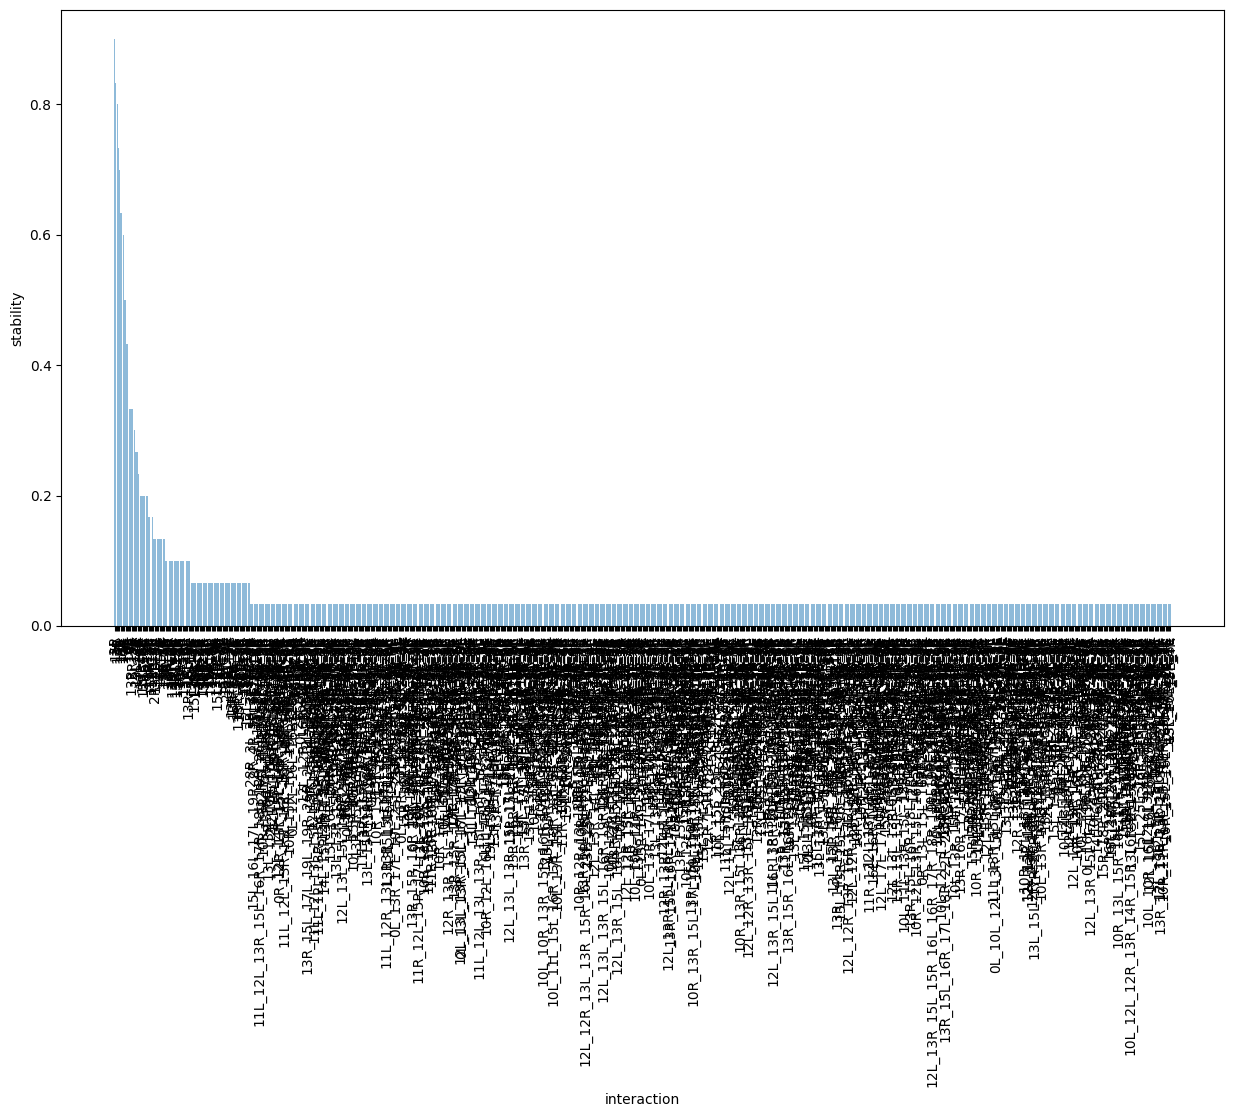

In [10]:
irf_jupyter_utils._get_histogram(stability_score, sort = True)